**Importing libraries**

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns

**Import the data**

In [2]:
dimensions = pd.read_csv('../data/dimensions.csv', index_col=0)

dimensions.head()

,sex,age,height(m),weight(kg),hip_size(cm),waist_size(cm)
0,1,21,1.740,65.6,93.5,71.5
1,1,23,1.753,71.8,94.8,79.0
2,1,28,1.935,80.7,95.0,83.2
3,1,23,1.865,72.6,94.0,77.8
4,1,22,1.872,78.8,98.5,80.0


Before continuing any further analysis let us split the data into training and split test.

Split the data, we are going to use stratifying sampling, for our training data set to be representative of the gender of the population. 

In [3]:
from sklearn.model_selection import train_test_split
strat_train_set, strat_test_set = train_test_split(
    dimensions, test_size=0.2,
    stratify=dimensions['sex'], random_state=42)

let us compare the proportions of a stratified, random sampling to that os the overall sampling based on the gender. 

In [4]:
def gender_proportion(data):
    return data['sex'].value_counts()/len(data)

train_set, test_set = train_test_split(dimensions, test_size=0.2, random_state=42)

compare_prop = pd.DataFrame({
    'overall %': gender_proportion(dimensions),
    'random %' : gender_proportion(test_set),
    'stratified %': gender_proportion(strat_test_set)
}).sort_index()

compare_prop['random. Error %'] = (compare_prop['random %']/
                                   compare_prop['overall %']-1)
compare_prop['strat. Error %'] = (compare_prop['stratified %']/
                                   compare_prop['overall %']-1)
compare_prop*100

,overall %,random %,stratified %,random. Error %,strat. Error %
sex,,,,,
0,51.282051,52.941176,50.980392,3.235294,-0.588235
1,48.717949,47.058824,49.019608,-3.405573,0.619195


As you can see the test set generated by the stratified sampling has the gender category almost identical to that in the ful dataset. Whereas the test set generated by the random sampling is skewed. 

**Exploring and visualizing the data to gain insight**

In [5]:
train_dimensions = strat_train_set.copy()

In [6]:
#Looking for correlation

corr_matrix = train_dimensions.corr()

# Looking at how much each attributes correlate with the waistband and hipsize
print("The correlation existing between each attributes and the waist_size is: ")
print(corr_matrix['waist_size(cm)'].sort_values(ascending=False))
print("\n")
print("The correlation existing between each attributes and the hip_size is: ")
corr_matrix['hip_size(cm)'].sort_values(ascending=False)

The correlation existing between each attributes and the waist_size is: 
waist_size(cm)    1.000000
weight(kg)        0.906597
hip_size(cm)      0.708215
sex               0.661744
height(m)         0.555382
age               0.355176
Name: waist_size(cm), dtype: float64


The correlation existing between each attributes and the hip_size is: 


hip_size(cm)      1.000000
weight(kg)        0.774216
waist_size(cm)    0.708215
height(m)         0.360802
age               0.235846
sex               0.171320
Name: hip_size(cm), dtype: float64

For the waist_size and hip_size, all the attributes has a positive correlation.

**Experimenting correlation with other attributes**

Let us see how the bmi index correlates with the target variables 

In [7]:
train_dimensions['bmi'] = train_dimensions['weight(kg)'] / (train_dimensions['height(m)'])**2
corr_matrix = train_dimensions.corr()
# Looking at how much each attributes correlate with the waistband and hipsize
print("The correlation existing between each attributes and the waist_size is: ")
print(corr_matrix['waist_size(cm)'].sort_values(ascending=False))
print("\n")
print("The correlation existing between each attributes and the hip_size is: ")
corr_matrix['hip_size(cm)'].sort_values(ascending=False)

The correlation existing between each attributes and the waist_size is: 
waist_size(cm)    1.000000
weight(kg)        0.906597
bmi               0.825119
hip_size(cm)      0.708215
sex               0.661744
height(m)         0.555382
age               0.355176
Name: waist_size(cm), dtype: float64


The correlation existing between each attributes and the hip_size is: 


hip_size(cm)      1.000000
bmi               0.810413
weight(kg)        0.774216
waist_size(cm)    0.708215
height(m)         0.360802
age               0.235846
sex               0.171320
Name: hip_size(cm), dtype: float64

The bmi index, has a strong positive correlation with both target variables, indicating that it will be advantageous to include a bmi column, to train our model.

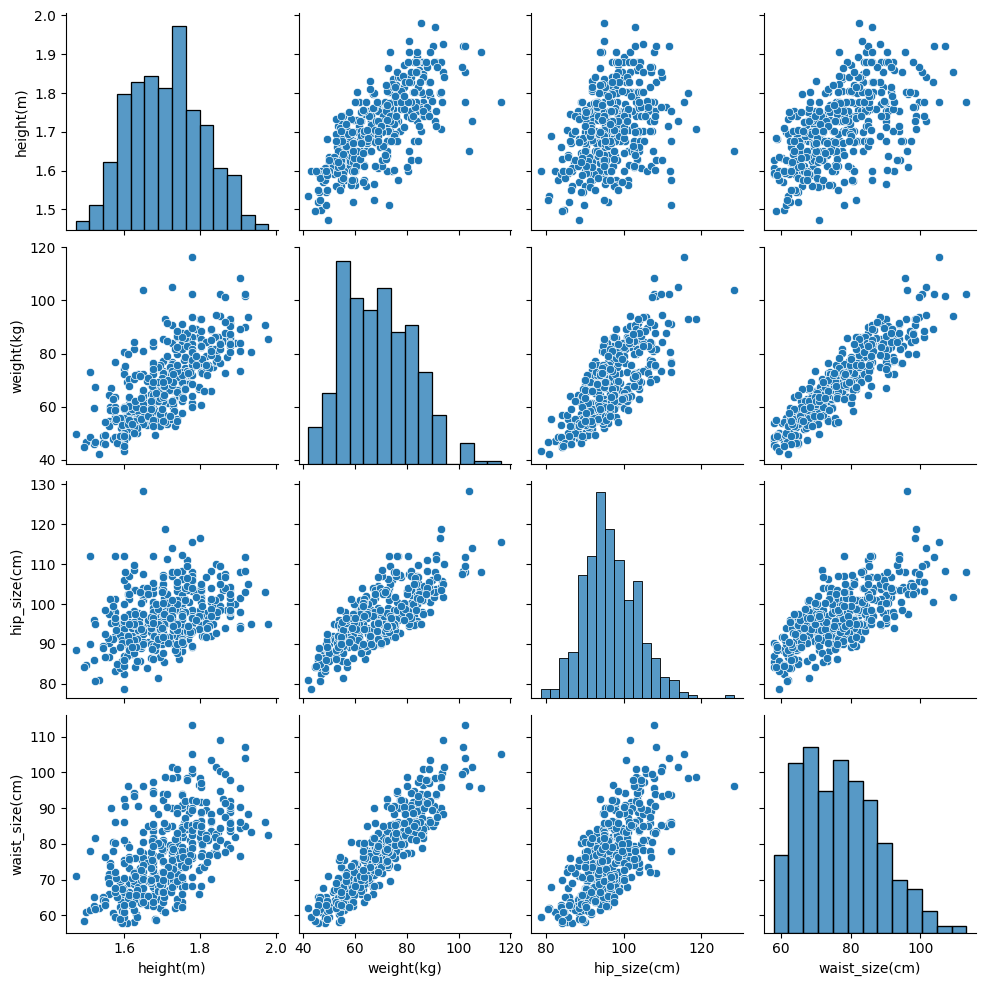

In [8]:
sns.pairplot(train_dimensions, vars=['height(m)', 'weight(kg)', 'hip_size(cm)','waist_size(cm)'])
plt.show()

The pairplots, shows a strong, positive and linear associations between each attributes. 

There appear to be an outlier in the hip_size histogram.

In [9]:
train_dimensions[train_dimensions['hip_size(cm)'] > 120]

,sex,age,height(m),weight(kg),hip_size(cm),waist_size(cm),bmi
473,0,43,1.651,104.1,128.3,96.2,38.190609


This is the only individual i'll remove as an outlier. 

**Preparing the data for the machine learning model.**

In [10]:
train_dimensions = strat_train_set.iloc[:, :4].copy()
train_dimensions_labels = strat_train_set.iloc[:, 4:].copy()


cleaning the data set 

#Handling outleirs as we said earlier, the indicidual at the index,  473 will be remove

In [11]:
train_dimensions = train_dimensions.drop(index=473)
train_dimensions
train_dimensions_labels = train_dimensions_labels.drop(index=473, axis=0)

**Feature scaling and transformation**

We'll proceed by creating functions and pipeline 

In [12]:
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer

In [13]:
def bmi(X:pd.DataFrame) -> float:
    '''
    Compute the BMI from dataframe of weight(kg) and hieght(m) columns
    
    parameters:
    X(pd.DataFrame): Dataframe containing weight in the first column and height in the second column.
    
    return: 
    float: BMI value.
    
    '''
    X = np.array(X)
    return X[:, [0]] / (X[:, [1]]**2)


In [14]:
#Custom features name out 
def column_name(function_transformer, feature_names_in):
    '''
    Generate feature names after transformation
    
    parameters:
        function_transformer: The function transformer instance 
        feature_names_in: list of features names
    
    return:
        list of output features names.
    '''
    return['value'] #feature name out. 


In [15]:
def bmi_pipeline():
    return make_pipeline(
        FunctionTransformer(bmi, feature_names_out=column_name),
        StandardScaler())
    
log_pipeline = make_pipeline(
    FunctionTransformer(np.log, feature_names_out="one-to-one"),
    StandardScaler()
)
default_pipeline = make_pipeline(StandardScaler())

preprocessing = ColumnTransformer([
    ('scale', default_pipeline, ['age', 'height(m)', 'weight(kg)']),
    ('log', log_pipeline, ['age']),
    ('bmi', bmi_pipeline(), ['weight(kg)', 'height(m)']),
])

In [16]:
# Applying the transformers on the training data.

train_dimensions_prep = preprocessing.fit_transform(train_dimensions)
preprocessing.get_feature_names_out()

array(['scale__age', 'scale__height(m)', 'scale__weight(kg)', 'log__age',
       'bmi__value'], dtype=object)

**Select and Train a Model**

In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error, mean_absolute_error

models = {
    "lin_reg":  make_pipeline(preprocessing, LinearRegression()),
    "tree_reg":  make_pipeline(preprocessing, RandomForestRegressor()),
    "multi_rf": make_pipeline(preprocessing, MultiOutputRegressor(RandomForestRegressor(), n_jobs=5)),
    "multi_lr": make_pipeline(preprocessing, MultiOutputRegressor(LinearRegression(), n_jobs=5)),
}

In [18]:
def fit_and_error(models, X_train, y_train):
    '''
    fit multiple models and compute training errors
    
    Parameters
    ----------
    models : dict
        Dictionary of model name -> estimator.
    X_train : DataFrame
        Training features.
    y_train : DataFrame
        Training targets.

    Returns
    -------
    dict
        Dictionary of model name -> {target_error: MAE}.
    '''
    
    #setting the random seed for reproducibility
    np.random.seed(42)
    
    #make a dictionary to keep the error
    model_error = {}
    
    for name, model in models.items():
        #fit the model to data
        model.fit(X_train, y_train)
        
        #make prediction 
        dimension_pred = model.predict(X_train)
        
        errors = {}
        for idx, col in enumerate(y_train.columns):
            errors[f'{col}_error'] = mean_absolute_error(y_train.iloc[:,idx], dimension_pred[:, idx])
        
        #Evaluate the model and append to its score 
        model_error[name] = errors
        
    return model_error

In [19]:
fit_and_error(models, train_dimensions,train_dimensions_labels)

{'lin_reg': {'hip_size(cm)_error': 3.004225252828967,
  'waist_size(cm)_error': 3.1154362663839246},
 'tree_reg': {'hip_size(cm)_error': 1.161574381188114,
  'waist_size(cm)_error': 1.2408735561056126},
 'multi_rf': {'hip_size(cm)_error': 1.1863303630362998,
  'waist_size(cm)_error': 1.2338235973597393},
 'multi_lr': {'hip_size(cm)_error': 3.004225252828968,
  'waist_size(cm)_error': 3.1154362663839246}}

Okay, the multi output regressor and the corresponding base estimators produces similar errors and the rf error is smaller than that of the linear regression. 

Let us proceed a better evaluation using the cross validtion. 

In [20]:
models = {
    "lin_reg":  make_pipeline(preprocessing, LinearRegression()),
    "tree_reg":  make_pipeline(preprocessing, RandomForestRegressor()),
}

from sklearn.model_selection import cross_val_score
for model in models:
    for col in train_dimensions_labels.columns:
        rmses = -cross_val_score(models[model], train_dimensions, train_dimensions_labels[col],
        scoring="neg_root_mean_squared_error", cv=5)
        print(f"{model} on {col}:\n", pd.Series(rmses).describe(), "\n")
        
    

lin_reg on hip_size(cm):
 count    5.000000
mean     3.796612
std      0.215920
min      3.513155
25%      3.702638
50%      3.758615
75%      3.935142
max      4.073509
dtype: float64 

lin_reg on waist_size(cm):
 count    5.000000
mean     4.026040
std      0.416730
min      3.553746
25%      3.617310
50%      4.159586
75%      4.339207
max      4.460350
dtype: float64 

tree_reg on hip_size(cm):
 count    5.000000
mean     4.003027
std      0.313957
min      3.641303
25%      3.861477
50%      3.958669
75%      4.062976
max      4.490709
dtype: float64 

tree_reg on waist_size(cm):
 count    5.000000
mean     4.261940
std      0.363387
min      3.726631
25%      4.069183
50%      4.402401
75%      4.477899
max      4.633589
dtype: float64 



Based on this cross validations, and others with increasing k-folds, the mean RMSE of the waist_size and hip_size of the linear_regression model is lower than that of the random forest model. And the linear regression model is more stable also, given the small amount of data( <600) in possessions. 

This could mean that the RFR overfit during the training process when we did not use the cross validation. 

**Fine Tunning the model**

In [21]:
linear_reg = make_pipeline(preprocessing, LinearRegression())
linear_reg.fit(train_dimensions, train_dimensions_labels)

,steps,"[('columntransformer', ...), ('linearregression', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('scale', ...), ('log', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [22]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint 

full_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("lin_reg", LinearRegression())
])

param_space = {'lin_reg__copy_X': [True,False], 
               'lin_reg__fit_intercept': [True,False], 
               'lin_reg__n_jobs': [1,5,10,15,None], 
               'lin_reg__positive': [True,False]}

random_search = RandomizedSearchCV(
    full_pipeline, param_space, random_state=42,
    n_iter=40, cv=5, scoring='neg_root_mean_squared_error')

random_search.fit(train_dimensions, train_dimensions_labels)


,estimator,Pipeline(step...egression())])
,param_distributions,"{'lin_reg__copy_X': [True, False], 'lin_reg__fit_intercept': [True, False], 'lin_reg__n_jobs': [1, 5, ...], 'lin_reg__positive': [True, False]}"
,n_iter,40
,scoring,'neg_root_mean_squared_error'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [23]:
random_search.best_params_

{'lin_reg__positive': True,
 'lin_reg__n_jobs': 1,
 'lin_reg__fit_intercept': True,
 'lin_reg__copy_X': True}

**Evaluating the system on the test set**

In [24]:
final_model = random_search.best_estimator_

In [25]:
X_test = strat_test_set.iloc[:, :4].copy()
y_test = strat_test_set.iloc[:, 4:].copy()
y_pred = final_model.predict(X_test)

In [26]:
#  

def actual_vs_pred_df(y_test, y_pred):
    '''
    compares the actual value to the predicted value.
    
    parameters:
        y_test: Dataframe
        y_pred: an array of the predicted values 
        
    return:
        a concatenate dataframe with the original index. 
    
    '''
    y_test = y_test.reset_index()
    y_pred_df = pd.DataFrame(y_pred, columns=['hipsize_pred', 'waistband_pred'])
    result_df = pd.concat([y_test, y_pred_df], axis=1)
    
    return result_df.set_index('index')

In [27]:
actual_vs_pred_df(y_test, y_pred)

,hip_size(cm),waist_size(cm),hipsize_pred,waistband_pred
index,,,,
162,99.6,98.0,104.453849,94.891013
299,92.2,64.9,91.583960,66.968711
92,92.0,81.5,99.375465,78.938278
297,95.8,68.6,93.104036,68.882099
416,93.2,69.3,93.592354,71.096055
...,...,...,...,...
168,108.1,98.5,108.679813,97.945516
224,103.3,94.7,104.727176,97.079937
59,95.8,82.9,98.382366,83.053364


In [28]:
#Evaluating the model 

for idx, col in enumerate(y_test.columns):
    print(f"{col}_RMSE:", root_mean_squared_error(y_test.iloc[:,idx], y_pred[:,idx]))

hip_size(cm)_RMSE: 3.5461759631664695
waist_size(cm)_RMSE: 4.170058143005147


In [29]:
from sklearn.metrics import r2_score
for idx, col in enumerate(y_test.columns):
    print(f"{col}_r2:", r2_score(y_test.iloc[:,idx], y_pred[:,idx]))

hip_size(cm)_r2: 0.6189298853824223
waist_size(cm)_r2: 0.8547373191269565


In [42]:
def waist_and_hip_size_pred(input_data:np.array) -> float:
    
    #changing the input_data into a dataframe
    input_data_as_df = pd.DataFrame(input_data,
                            columns=['sex', 'age', 'height(m)', 'weight(kg)'])
    
    # The model predicts two out out_put eg. ([[97, 73]]). one row , two columns. 
    hip_size = float(round(final_model.predict(input_data_as_df)[0, 0], 2)) # index for the rows, columns. 
    waist_size = float(round(final_model.predict(input_data_as_df)[0, 1], 2))
    
    return waist_size, hip_size

In [ ]:
waist, hip = (waist_and_hip_size_pred([[0, 20, 1.60, 85]]))

91.63

In [31]:
my_info = pd.DataFrame([[0, 20, 1.60, 85]],
                            columns=['sex', 'age', 'height(m)', 'weight(kg)'])
waist_size = round(final_model.predict(my_info)[0, 1], 2)
hip_size = round(final_model.predict(my_info)[0, 0], 2)
print(f"Your estimated waistband is {waist_size}cm and the estimated hip_size is {hip_size}cm")

Your estimated waistband is 91.63cm and the estimated hip_size is 109.73cm


**Save the model**

In [32]:
import joblib
import os 

#create models folder if it does not exist. 
os.makedirs("models", exist_ok=True)

filename = os.path.join("models", "my_waistband_model.pkl")

joblib.dump(final_model, open(filename, "wb"))
